In [1]:
##########----------##########----------##########----------##########----------

# Libraries, setup, and general use objects

In [2]:
## import full libraries
import urllib.request as url
import pandas as pd
import numpy as np
import ipyparallel as ipp
import pickle
import datetime as dt
import matplotlib.pyplot as plt

## import needed functons from libraries
from bs4 import BeautifulSoup
from os import listdir, mkdir
from os.path import isdir, isfile
from matplotlib.colors import hsv_to_rgb, to_hex
from matplotlib.gridspec import GridSpec
from sklearn.metrics   import f1_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans


## define settings
set_gather_data = False
set_refresh_sample = False
set_roll_window = 15
set_year_middle = 213
set_sample_frac = 1 / 10
set_parallel_cores = {'Download': 4, 'Model':12}
valid_prefix = [69, 72, 74, 91, 99]
use_col_list = {'DATE':str, 'LATITUDE':float, 'LONGITUDE':float,
    'ELEVATION':float, "HourlyDryBulbTemperature":float,
                "HourlyPrecipitation":float}

## define simple timing function
def time_check(s = 'A'):
    print('Time Check: Point ' + s)
    print(dt.datetime.now())
time_check('A')

## read in general purpose input files
with open('A_Input/year_links.txt', 'r') as conn:
    year_links = conn.readlines()
    conn.close()
for i in range(len(year_links)):
    year_links[i] = year_links[i].strip()
    
    
city_list = pd.read_excel('A_Input/city_list.xlsx')
city_list = city_list.rename({'lon':'Lon', 'lat':'Lat'}, axis = 1)

print(
    '\n' +\
    'WARNING: Copies of city_list.xlsx used in two different projects.\n' +\
    '         Treat the us_travels version as the master version.\n' +\
    '         Sync this travel_weather version to it.'
)

Time Check: Point A
2022-03-07 21:21:19.583603

         Treat the us_travels version as the master version.
         Sync this travel_weather version to it.


#### Execute basic set-up automations

In [3]:
## make directories that script expects
def make_directories():
    all_dirs = ['A_Input', 'B_Process', 'C_Output']
    all_dirs = all_dirs + ['B_Process/downloads', 'B_Process/model_data']
    for i in all_dirs:
        if not isdir(i): mkdir(i)
        
make_directories()

## set geographic bounding box
set_geo_box = ~city_list.State.isin(['AK', 'HI'])
set_geo_box = city_list[['Lon', 'Lat']].loc[set_geo_box, :]
set_geo_box = {
    'Lon': (set_geo_box.Lon.min(), set_geo_box.Lon.max()),
    'Lat': (set_geo_box.Lat.min(), set_geo_box.Lat.max()),
    }

# Import Data

#### extract_links

In [4]:
def extract_links(address):
    
    ## retrieve raw web page
    url_connect = url.urlopen(address)
    all_links = url_connect.read()
    url_connect.close()
    
    ## extract all links to csv files
    all_links = BeautifulSoup(all_links)
    all_links = all_links.find_all('a')
    all_links = [i.string for i in all_links if i.string.find('.csv') != -1]
    
    ## eliminate files unlikely to represent US weather stations
    def us_range(x, target_range = valid_prefix):
        try:
            int(x[0:2])
        except:
            return False
        if int(x[0:2]) in target_range:
            return True
        else:
             return False
    all_links = filter(us_range, all_links)
    
    ## remove url if files have already been downloaded
    already_downloaded = listdir('B_Process/downloads')
    valid_links = list()
    for i in all_links:
        if address[-5:-1] + '_' + i + '.gz' in already_downloaded:
            pass
        else:
            x = address[-5:-1] + '_' + i + '.gz'
            y = address + i
            valid_links.append((x, y))
            
    return valid_links

#### download_files

In [5]:
def download_files(links_ext, ucl = use_col_list):
    import pandas as pd
    try:
        the_csv = pd.read_csv(links_ext[1], usecols = list(ucl.keys()),
            parse_dates = ['DATE'], dtype = ucl)
    except:
        the_csv = pd.read_csv(links_ext[1], usecols = list(ucl.keys()),
            parse_dates = ['DATE'], dtype = str)
        for j in ucl.keys():
            if ucl[j] == float:
                the_csv[j] = pd.to_numeric(the_csv[j], errors = 'coerce')
        
    the_csv = the_csv.round(4)
    the_csv.to_csv('B_Process/downloads/' + links_ext[0], encoding = 'utf-8',
                    index = False)

#### Execute code

In [6]:
if set_gather_data:

    ## iterative extract files from the links on each directory page
    for i in year_links:
        links_extracted = extract_links(i)
        if len(links_extracted) < 1: continue
    
        with ipp.Cluster(n = set_parallel_cores['Download']) as rc:
            par_processes = rc.load_balanced_view()
            par_result = par_processes.map_async(download_files, links_extracted)
            par_result.wait_interactive()
            final_result = par_result.get()
            del par_processes, par_result, final_result

# Refine Data

#### refine_data (and compile)

In [7]:
def refine_data(file_dir, segment, ucl = use_col_list,
                sample_fraction = set_sample_frac):
    
    ## generate roster of files
    list_files = listdir(file_dir)
    list_files = [i for i in list_files if i[0] != '.']
    
    ## filter files to specified segment
    def us_range(x, target_range = segment):
        try:
            x[0:7]
        except:
            return False
        if x[0:7] in target_range:
            return True
        else:
             return False
    list_files = filter(us_range, list_files)
    
    ## assemble files
    all_data = list()
    for i in list_files:
        file_iter = pd.read_csv(file_dir + '/' + i, parse_dates = ['DATE'],
                                dtype = ucl)
        
        ## deconstruct day/times
        file_iter['Day'] = file_iter['DATE'].dt.dayofyear
        file_iter['Hour'] = file_iter['DATE'].dt.hour
        file_iter = file_iter.drop('DATE', axis = 1)
        
        ## score weather
        file_iter['HourlyPrecipitation'] = file_iter[
            'HourlyPrecipitation'].fillna(0)
        file_iter['Temperate'] = (file_iter['HourlyDryBulbTemperature'] > 55) &\
            (file_iter['HourlyDryBulbTemperature'] < 75) &\
            (file_iter['HourlyPrecipitation'] < 0.4)
        file_iter['Temperate'] = file_iter['Temperate'].astype(int)
        file_iter = file_iter.drop(['HourlyDryBulbTemperature',
            'HourlyPrecipitation'], axis = 1)
        
        ## rename columns to make capitalization consistent
        file_iter = file_iter.rename(columns = {'LATITUDE':'Lat',
            'LONGITUDE': 'Lon', 'ELEVATION':"Elev"})
        
        ## sample data if specified
        if sample_fraction < 1:
            assert sample_fraction > 0
            sample_n = file_iter.shape[0] * sample_fraction
            sample_n = int(sample_n)
            sample_n = np.max([sample_n, int((0.5**2)/(0.05**2))])
            sample_n = np.min([sample_n, file_iter.shape[0]])
            file_iter = file_iter.sample(
                n = int(sample_n),
                weights = (file_iter['Temperate'] * 1) + 1
            )

        ## drop files outside the US's rough lat/lon box; append others
        xy_mean = file_iter[['Lon', 'Lat']].mean()
        
        if xy_mean.Lat >= min(set_geo_box['Lat']
                             ) and xy_mean.Lat <= max(set_geo_box['Lat']):
            if xy_mean.Lon >= min(set_geo_box['Lon']
                            ) and xy_mean.Lon <= max(set_geo_box['Lon']):
                all_data.append(file_iter)
                
        ## create exception for honolulu (-157.858333, 21.306944)
        set_hono_box = {
            'Lon':(-157.86 - 1, -157.86 + 1),
            'Lat':(  21.31 - 1,   21.31 + 1),
        }
        if xy_mean.Lat >= min(set_hono_box['Lat']
                             ) and xy_mean.Lat <= max(set_hono_box['Lat']):
            if xy_mean.Lon >= min(set_hono_box['Lon']
                            ) and xy_mean.Lon <= max(set_hono_box['Lon']):
                all_data.append(file_iter)

    ## compile files and save
    if len(all_data) > 0:
        all_data = pd.concat(all_data, axis = 0)
        all_data.to_csv('B_Process/model_data/' + str(segment[0]) +\
            '_weather_data.csv.gz', index = False, encoding = 'utf-8')
        return all_data
    else:
        print('WARNING: ' + str(segment[0]) + ' files contain no valid data')

#### load_model_data

In [8]:
def load_model_data(file_directory = 'B_Process/model_data'):
    all_data = listdir(file_directory)
    all_data = [i for i in all_data if i[-6:] == 'csv.gz']
    for i in range(len(all_data)):
        all_data[i] = pd.read_csv(file_directory + '/' + all_data[i])
    all_data = pd.concat(all_data, axis = 0)
    all_data.reset_index()
    return all_data

#### Execute Code

In [9]:
if set_gather_data or set_refresh_sample:
    for i in valid_prefix:
        for j in range(2017, 2022):
            segment_iter = [str(j) + '_' + str(i)]
            refine_data('B_Process/downloads', segment = segment_iter)

model_data = load_model_data()

# Build Model

#### split data into train and test subsets

In [10]:
## split data into train and test subsets
model_data.loc[:, 'Split'] = np.random.binomial(
    n = 1, size = (model_data.shape[0],), p = 0.8).astype(bool)

#### model_weather

In [11]:
def find_closest_means(new_data, mod):
    new_data = new_data[['Lon', 'Lat', 'Day', 'Hour']]
    return mod.predict(new_data)

def model_weather(dat = model_data):
    
    ## split data into train and test data
    test_data = dat[~dat['Split']]
    dat = dat[dat['Split']]
    
    ## round off data and average for each rounded grid
    simple_dat = dat.drop(['Elev', 'Split'], axis = 1).round()
    simple_dat.loc[:, 'Day']  = np.ceil(simple_dat.loc[:, 'Day']  / 5) * 5
    simple_dat.loc[:, 'Hour'] = np.ceil(simple_dat.loc[:, 'Hour'] / 2) * 2
    simple_dat.loc[:, ['Lon', 'Lat', 'Day', 'Hour']] = simple_dat.astype(int)
    simple_dat = simple_dat.groupby(['Lon', 'Lat', 'Day', 'Hour']).mean()
    simple_dat = simple_dat.reset_index()
    
    ## train k nearest neighbor model
    knn_model = KNeighborsRegressor(weights = 'distance')
    knn_model = knn_model.fit(
                                simple_dat[['Lon', 'Lat', 'Day', 'Hour']],
                                simple_dat['Temperate']
                                )
    
    ## save model to file
    with open('B_Process/knn_model.pkl', 'wb') as conn:
        pickle.dump(knn_model, conn)
        conn.close()
    
    ## announce accuracy of predictor function
    ml_score = find_closest_means(test_data, knn_model) > 0.5
    ml_score = ml_score.astype(int)
    ml_score = f1_score(test_data['Temperate'].values, ml_score).round(2)
    print('Weather Model F1: ' + str(ml_score) + ' (Threshold = 0.5)')
    
    return knn_model

#### Execute Code

In [12]:
if isfile('B_Process/knn_model.pkl') and ~set_refresh_sample:
    with open("B_Process/knn_model.pkl", 'rb') as conn:
        weather_model = pickle.load(conn)
        conn.close()
else:
    weather_model = model_weather()

# Model Routes

#### model_city

In [13]:
def model_city(pd_nxy, mod):
    
    ## warn if outside range
    geo_bound_check = [
        pd_nxy.Lon <= max(set_geo_box['Lon']),
        pd_nxy.Lon >= min(set_geo_box['Lon']),
        pd_nxy.Lat <= max(set_geo_box['Lat']),
        pd_nxy.Lat >= min(set_geo_box['Lat'])
        ]
    
    if all(geo_bound_check):
        pass
    else:
        print('WARNING: ' + pd_nxy.City + ' is outside the geographic' +\
             ' bounds used to create the model.  Results may be inaccurate.\n')
    
    ## expand data to include all days of the year and hours of the day
    full_data = np.meshgrid(np.arange(1, 366), np.arange(0, 24))
    full_data = pd.DataFrame(map(np.ravel, full_data)).T
    full_data.columns = ['Day', 'Hour']
    for i in pd_nxy.index:
        full_data[i] = pd_nxy[i]
    
    ## predict weather
    full_data['Temperate'] = find_closest_means(full_data, mod)
    return full_data

#### model_routes

In [14]:
def model_route(route, cl = city_list, mod = weather_model):
    
    ## extract coordinates of cities on the route
    pd_nxy = cl.loc[cl.Route == route, ['City', 'Lon', 'Lat']]
    
    ## predict weather conditions for each set of coordinates
    route_weather = []
    for i in range(pd_nxy.shape[0]):
        city_iter = pd_nxy.iloc[i,:]
        route_weather.append(model_city(city_iter, mod))
    route_weather = pd.concat(route_weather, axis = 0)
    
    ## score each day for temperate weather across routes
    i = route_weather.Hour
    route_weather = route_weather[(i > 7) & (i < 23)]
    route_weather = route_weather.drop(['Lon', 'Lat', 'City', 'Hour'], axis = 1)
    route_weather = route_weather.groupby('Day').mean().round(4)
    route_weather = route_weather.reset_index()

    ## inject route name into dataset and reorder
    route_weather['Route'] = route
    i = ['Route', 'Day', 'Temperate']
    route_weather = route_weather[i]
    
    ## add moving average
    i = np.concatenate((np.arange(365 - set_roll_window + 1, 365
        ), np.arange(0, 365)))
    route_weather = route_weather.loc[i, ]
    route_weather['Mean15d'] = route_weather.Temperate.rolling(set_roll_window
        ).mean()
    route_weather = route_weather.round(4).dropna()
    
    return route_weather

#### find_best_month

In [15]:
def find_best_month(rm):
    
    ## divide the year into two halves
    rm['Half'] = (rm['Day'] >= set_year_middle).astype(int)
    
    ## find the best 15-day moving mean score for each route and half-year
    rm['Best'] = rm.groupby(['Route', 'Half']).Mean15d.transform(max)
    rm['Best'] = rm['Best'] == rm['Mean15d']
    
    ## translate day of the year into date
    rm['Date'] = pd.to_datetime(rm['Day'] - 1, unit = 'D',
        origin = dt.datetime(2019, 1, 1)).astype(str)
    for i in range(len(rm)):
        rm.Date.iat[i] = rm.Date.iat[i][5:]
     
    return rm[rm['Best']].round(2)

#### execute code

In [16]:
## Score average temperateness for all cities across each route
routes_modeled = []
for i in set(city_list.Route):
    routes_modeled.append(model_route(i))
routes_modeled = pd.concat(routes_modeled)

## find best 15 day ranges in the each half of the year for each route
best_month = find_best_month(rm = routes_modeled.copy())
best_month.to_excel('C_Output/best_month_for_route.xlsx', index = False)

## do final rounding and misc.
routes_modeled['Date'] = pd.to_datetime(routes_modeled['Day'], unit = 'D',
        origin = dt.datetime(dt.datetime.now().year - 1, 12, 31))

# Render Visualization

#### set style parameters

In [17]:
plt.rcParams['font.sans-serif'] = ['Quicksand']
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

#### render_data

In [18]:
def render_data(rm = routes_modeled.copy()):
    
    ## score each route on a summer to winter scale
    rm['Summer'] = (rm['Day'] - set_year_middle).abs() * rm['Temperate']
    routes = rm.groupby('Route').sum()[['Summer', 'Temperate']]
    routes['Summer'] = routes['Summer'] / routes['Temperate']
    routes = routes.drop('Temperate', axis = 1).round(4)
    routes = routes.sort_values('Summer')
    
    ## calculate colors
    h = 0
    for i in routes.index:
        temp = hsv_to_rgb(((h % 12) / 12, 1/2, 3/4))
        routes.at[i, 'Color'] = to_hex(temp)
        h += 1
        
    ## divide routes into plots
    route_plot = np.array(routes.Summer).reshape(-1, 1)
    route_plot = KMeans(n_clusters = 3).fit_predict(route_plot)
    f = lambda ii: int(route_plot[ii] != route_plot[ii - 1])
    route_plot = [0] + [f(i) for i in range(1, len(route_plot))]
    route_plot = np.cumsum(route_plot)
    routes['Plot'] = route_plot

    ## express route object and route weather trendline coordinates
    return {'routes':routes, 'xy':rm.set_index('Route')[['Date', 'Mean15d']]}

#### render_infrastructure

In [31]:
from matplotlib.dates import DateFormatter

def render_infrastructure():
    
    ## set up basic plotting space as a 2x2 grid
    weather_fig = plt.figure(figsize = (8, 6), tight_layout = True)
    weather_gs = GridSpec(nrows = 2, ncols = 2)
    weather_ax = [
        weather_fig.add_subplot(weather_gs[i]) for i in range(0, 4)]
    
    ## set basic axis labels
    for i in range(0, len(weather_ax)):
        weather_ax[i].set_ylim(-0.01, 1.2)
        just_the_month = DateFormatter('%b')
        weather_ax[i].xaxis.set_major_formatter(just_the_month)
        
    ## turn off axis for
    weather_ax[3].set_axis_off()
    
    return weather_ax

#### render_explanation

In [ ]:
def render_explanation(x):
    ## add returns to text
    ## render text
    pass

#### render_weather

In [32]:
def render_weather(p_dat, p_ax):
    
    ##
    routes = p_dat['routes']
    xy = p_dat['xy']
    
    for i in routes.Plot:
        
        ## plot legends for each plot
        col_iter = 1
        if sum(i == routes.Plot) > 3: col_iter = 2
        
        p_ax[i].legend(
            labels = routes.index[i == routes.Plot],
            labelcolor = routes.Color[i == routes.Plot],
            ncol = col_iter,
            fontsize = 6
            )
        
        ## plot 'now' line for each plot
        p_ax[i].vlines(
            x = [dt.datetime(2022, i, 1) for i in range(1, 13, 2)] +\
            [dt.datetime(2023, 1, 1)],
            ymin = 0, ymax = 1.2,
            color = '#303030',
            linestyle = '-',
            label = '_nolegend_',
            linewidth = 0.1
            )
        p_ax[i].hlines(
            y = 0.5,
            xmin = dt.datetime(2022, 1, 1), xmax = dt.datetime(2023, 1, 1),
            color = '#303030',
            linestyle = '-',
            label = '_nolegend_',
            linewidth = 0.1
            )
        
        ## plot temperate weather scores for each route
        for j in routes.index[i == routes.Plot]:
            p_ax[i].plot(
                xy.loc[j, 'Date'],
                xy.loc[j, 'Mean15d'],
                color = routes.loc[j, 'Color']
                )
    
    plt.gcf().savefig('C_Output/probability_of_temperate.pdf')

#### execute

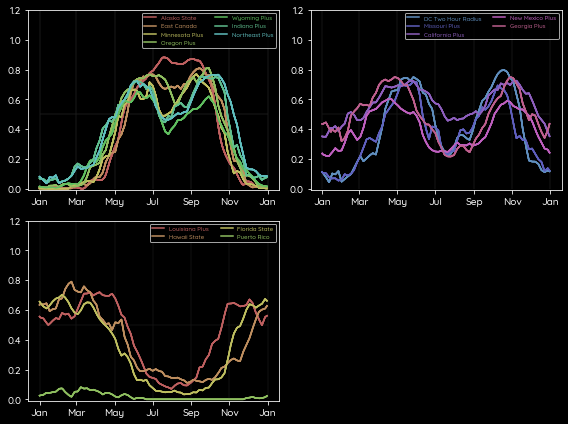

In [33]:
plot_data = render_data()
plot_ax = render_infrastructure()
render_weather(p_dat = plot_data, p_ax = plot_ax)

# Misc.

In [22]:
time_check('Z')

Time Check: Point Z
2022-03-07 21:21:59.980959
